In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t')

C:\Users\nberraba\AppData\Local\Temp\ipykernel_13212\2156673982.py:1: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t')


# Nettoyage des données

## Repérer variables pertinentes

In [3]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#dimensions du jeu de données

df.shape

(320772, 162)

In [5]:
#suppression colonnes vides

df.dropna(axis=1, how='all', inplace=True)

In [6]:
df.shape

(320772, 146)

### Caractéristiques principales

L'objectif étant de connaître la qualité nutritionnelle des produits, nous ne garderont que:
 - le nom du produit
 - le nutriscore (nombre) français
 - le nutriscore (lettre) français
 - les valeurs nutritionnelles des produits

In [7]:
caracteristiques_princip = ['product_name', 'nutrition_grade_fr' ]

In [8]:
#liste de toutes les colonnes en rapport avec les valeurs nutritionnelles

val_nutri = [col for col in df.columns if col.endswith('_100g')]

In [9]:
caracteristiques_princip = caracteristiques_princip + val_nutri

In [10]:
# calcule du pourcentage de valeurs manquantes pour les valeurs nutritonnelles

pourcentage_valeurs_manquantes = (df[val_nutri].isnull().sum() / len(df)) * 100

print(f'Il y a en moyenne {round(pourcentage_valeurs_manquantes.mean(), 1)} % de valeurs manquantes par colonne.')

Il y a en moyenne 86.9 % de valeurs manquantes par colonne.


On voit qu'il manque en moyenne un grand nombre de données pour les colonnes sélectionnées.
Ajoutons donc d'autre colonnes qui pourraient nous aider à combler ses valeurs manquantes.

Dans un premier temps, faisons une large sélection avant de sélectionner plus précisémment.

### Caractéristiques secondaires

In [11]:
categorie = ['categories', 'categories_fr', 'categories_tags', 'main_category', 'main_category_fr']
label = ['labels', 'labels_tags', 'labels_fr'] 
ingredient = ['ingredients_text','traces', 'traces_tags'] 
additif = ['additives_tags', 'additives','additives_fr', 'additives_n']
huile_palme =['ingredients_from_palm_oil_n','ingredients_from_palm_oil_tags']
nutriscore = ['nutrition_grade_fr']

In [12]:
# analyse de la liste categorie
df[categorie].describe(include='object')

,categories,categories_fr,categories_tags,main_category,main_category_fr
count,84410,84411,84389,84366,84366
unique,36982,21152,21142,3543,3543
top,"Snacks sucrés,Biscuits et gâteaux,Biscuits","Snacks sucrés,Biscuits et gâteaux,Biscuits","en:sugary-snacks,en:biscuits-and-cakes,en:bisc...",en:beverages,Boissons
freq,301,802,802,6054,6054


In [13]:
# 40 lignes des colonnes catégorie, où aucune valeur nulle n'est présente

df[categorie].dropna(subset=categorie, how='any').head(40)

,categories,categories_fr,categories_tags,main_category,main_category_fr
46,Filet de bœuf,Filet-de-boeuf,fr:filet-de-boeuf,fr:filet-de-boeuf,Filet-de-boeuf
174,Légumes-feuilles,"Aliments et boissons à base de végétaux,Alimen...","en:plant-based-foods-and-beverages,en:plant-ba...",en:fresh-vegetables,Légumes frais
175,"Snacks sucrés,Biscuits et gâteaux,Pâtisseries","Snacks sucrés,Biscuits et gâteaux,Pâtisseries","en:sugary-snacks,en:biscuits-and-cakes,en:past...",en:pastries,Pâtisseries
177,"Plant-based foods and beverages,Plant-based fo...","Aliments et boissons à base de végétaux,Alimen...","en:plant-based-foods-and-beverages,en:plant-ba...",en:breads,Pains
180,"Snacks sucrés,Biscuits et gâteaux,Pâtisseries","Snacks sucrés,Biscuits et gâteaux,Pâtisseries","en:sugary-snacks,en:biscuits-and-cakes,en:past...",en:pastries,Pâtisseries
181,Boulange,Boulange,fr:boulange,fr:boulange,Boulange
182,"Aliments et boissons à base de végétaux,Alimen...","Aliments et boissons à base de végétaux,Alimen...","en:plant-based-foods-and-beverages,en:plant-ba...",en:plant-based-foods-and-beverages,Aliments et boissons à base de végétaux
183,Root bier,Root-bier,fr:root-bier,fr:root-bier,Root-bier
184,"Snacks sucrés,Biscuits et gâteaux,Biscuits,Sablés","Snacks sucrés,Biscuits et gâteaux,Biscuits,Sablés","en:sugary-snacks,en:biscuits-and-cakes,en:bisc...",fr:sables,Sablés
185,Quiches lorraines,"Plats préparés,Pizzas tartes salées et quiches...","en:meals,en:pizzas-pies-and-quiches,en:quiches...",en:meals,Plats préparés


La colonnes à garder comme caractéristique secondaire est 'main_category_fr' car :
  - dénominations françaises
  - dénominations plus concises  
  - pas moins de valeurs que les autres colonnes

In [14]:
caracteristiques_sec = ['main_category_fr']

In [15]:
# analyse de la liste label
df[label].describe(include='object')

,labels,labels_tags,labels_fr
count,46559,46644,46666
unique,18114,13653,13655
top,"Organic, EU Organic, fr:AB Agriculture Biologique","en:organic,en:eu-organic,fr:ab-agriculture-bio...","Bio,Bio européen,AB Agriculture Biologique"
freq,3223,5311,5311


In [16]:
# 40 lignes des colonnes label, où aucune valeur nulle n'est présente

df[label].dropna(subset=label, how='any').head(40)

,labels,labels_tags,labels_fr
182,AB,"en:organic,en:eu-organic,fr:ab-agriculture-bio...","Bio,Bio européen,AB Agriculture Biologique"
184,Point Vert,en:green-dot,Point Vert
187,"Sans arômes artificiels,Contient des OGM","en:no-artificial-flavors,fr:contient-des-ogm","Sans arômes artificiels,Contient-des-ogm"
192,Incorrect data on label,en:incorrect-data-on-label,Informations incorrectes sur l'emballage
218,UTZ Certified Kakao,"en:sustainable-farming,en:utz-certified,en:utz...","Agriculture durable,UTZ Certified,UTZ Certifie..."
239,"Vegetariano,Vegano","en:vegetarian,en:vegan","Végétarien,Végétalien"
279,"Fabriqué en France,Point Vert","en:green-dot,en:made-in-france","Point Vert,Fabriqué en France"
283,"Point Vert,Fabriqué en France","en:green-dot,en:made-in-france","Point Vert,Fabriqué en France"
297,"Vegetarisch,Vegan","en:vegetarian,en:vegan","Végétarien,Végétalien"
299,"Point Vert,Fabriqué en France","en:green-dot,en:made-in-france","Point Vert,Fabriqué en France"


La colonnes à garder comme label est 'label_fr' car :
  - dénominations françaises 
  - pas moins de valeurs que les autres colonnes

In [17]:
# analyse de la liste ingredient
df[ingredient].describe(include='object')

,ingredients_text,traces,traces_tags
count,248962,24353,24329
unique,205520,8378,3578
top,"Carbonated water, natural flavor.",Fruits à coque,en:nuts
freq,222,1240,2051


In [18]:
# 40 lignes des colonnes ingrédients, où aucune valeur nulle n'est présente

df[ingredient].dropna(subset=ingredient, how='any').head(40)

,ingredients_text,traces,traces_tags
47,pasteurized free range egg.sugar.blueberries (...,"milk, egg,","en:eggs,en:milk"
153,"milk chocolate (32%) (sugar, cocoa butter, dri...","nuts, milk, soya, wheatflour, gluten, oatmeal,...","en:eggs,en:gluten,en:milk,en:nuts,en:soybeans,..."
174,INGREDIENTS : LAITUE. VINAIGRETTE (HUILE DE CA...,CONTIENT : OEUF. LAIT. ANCHOIS. SOYA. BLE. SEI...,fr:contient-oeuf-lait-anchois-soya-ble-seigle-...
180,"Ingrédients : Pâte (farine, margarines d'huile...","Soja,Anhydride sulfureux et sulfites,Contient ...","en:soybeans,en:sulphur-dioxide-and-sulphites,f..."
181,"Ingrédients : Farine, eau, sel, levure, orge m...","Blé,Orge,Peut contenir: Noix variés Soya Lait...","en:gluten,fr:peut-contenir-noix-varies-soya-la..."
184,"Sucre, farine de _Blé_, graisse et huiles végé...","Fruits à coque,Graines de sésame,Soja","en:nuts,en:sesame-seeds,en:soybeans"
188,"Thé noir de Chine, zestes d'oranges 7,5 %, arô...","Œufs,Gluten,Lait,Moutarde,Fruits à coque,Grain...","en:eggs,en:gluten,en:milk,en:mustard,en:nuts,e..."
218,"Zucker, Kakaomasse, Kakaobutter, _Vollmilchpul...","Ei,Gluten,Schalenfrüchte,Alkohol","en:eggs,en:gluten,en:nuts,de:alkohol"
221,77,"macadamia nuts,",sl:macadamia-nuts
235,"malted barley, water, hops, yeast","barley, yeast","en:gluten,yeast"


La colonnes à garder comme ingrédient est 'ingrédients_text' car :
  - beaucoup plus de valeurs que les deux autres colonnes
  - traces sont de plus les aliments présents en faible quantité, ce qui n'impact pas le nutriscore

In [19]:
caracteristiques_sec.append('ingredients_text')

In [20]:
# analyse de la liste additif
df[additif].describe(include='object')

,additives_tags,additives,additives_fr
count,154680,248905,154680
unique,41537,196069,41537
top,en:e322,[ extra-virgin-olive-oil -> en:extra-virgin-o...,E322 - Lécithines
freq,8264,397,8264


In [21]:
df[additif].describe()

,additives_n
count,248939.000000
mean,1.936024
std,2.502019
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,31.000000


In [22]:
# 40 lignes des colonnes additifs, où aucune valeur nulle n'est présente

df[additif].dropna(subset=additif, how='any').head(40)

,additives_tags,additives,additives_fr,additives_n
7,"en:e123,en:e307a",[ org-oats -> en:org-oats ] [ oats -> en:oa...,"E123 - Amarante,E307a - Tocophérol",2.0
12,en:e100,[ roasted-peanuts -> en:roasted-peanuts ] [...,E100 - Curcumine,1.0
21,en:e322,[ chocolate-stars -> en:chocolate-stars ] [...,E322 - Lécithines,1.0
23,"en:e339iii,en:e330",[ dry-roasted-almonds -> en:dry-roasted-almon...,"E339iii - Phosphate de sodium tribasique,E330 ...",2.0
24,"en:e170,en:e322,en:e410",[ peanut-butter -> en:peanut-butter ] [ but...,"E170 - Carbonate de calcium,E322 - Lécithines,...",3.0
28,en:e100,[ cashews -> en:cashews ] [ curry-seasoning...,E100 - Curcumine,1.0
29,en:e330,[ almonds -> en:almonds ] [ wasabi-spice ->...,E330 - Acide citrique,1.0
32,en:e322,[ coconut-bar -> en:coconut-bar ] [ bar -> ...,E322 - Lécithines,1.0
33,en:e322,[ organic-semi-sweet-chocolate-chips -> en:or...,E322 - Lécithines,1.0
43,en:e322,[ dark-chocolate-coating -> en:dark-chocolate...,E322 - Lécithines,1.0


'additives' fait redondance avec 'ingredient_text'

'additives_tags' et 'additives_fr' semblent être similaire, mais additives_fr est en français.

'additives_n' correspond au nombre d'additifs présents dans le produits.

Comme caractéristiques secondaires, 'additives_fr' et 'additives_n' seront gardées.

In [23]:
caracteristiques_sec.append('additives_fr')
caracteristiques_sec.append('additives_n')

In [24]:
# analyse de la liste huile_palme
df[huile_palme].describe(include='object')

,ingredients_from_palm_oil_tags
count,4835
unique,14
top,huile-de-palme
freq,4586


In [25]:
df[huile_palme].describe()

,ingredients_from_palm_oil_n
count,248939.000000
mean,0.019659
std,0.140524
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2.000000


In [26]:
df['ingredients_from_palm_oil_n'].value_counts()

ingredients_from_palm_oil_n
0.0    244104
1.0      4776
2.0        59
Name: count, dtype: int64

Trop peu de produits renseignés avec de l'huile de palme, pour éviter le bruit, non utilisations de ces données.

In [27]:
# analyse de la liste huile_palme
df[nutriscore].describe(include='object')

,nutrition_grade_fr
count,221210
unique,5
top,d
freq,62763


Valeurs assez reinseignées suffisantes et pouvant être utile à remplir d'autres champs.

In [28]:
caracteristiques_sec.append('nutrition_grade_fr')

In [54]:
df_2 = df[caracteristiques_princip + caracteristiques_sec]

In [30]:
print('Le nombre de colonnes restantes est de: ', df_2.shape[1])

Le nombre de colonnes restantes est de:  94


<Axes: >

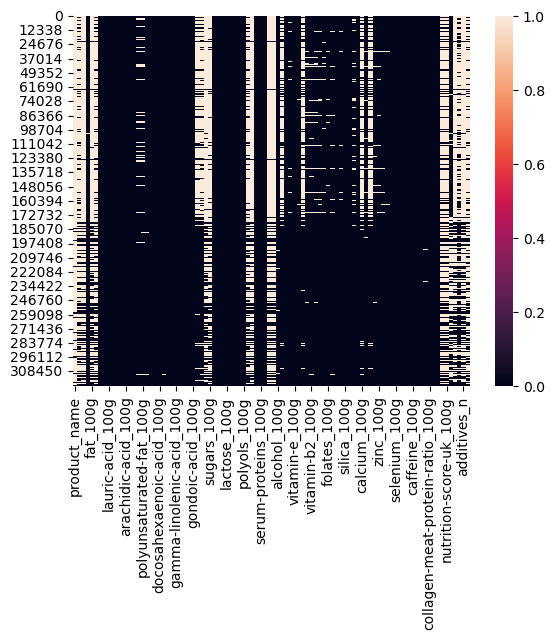

In [40]:
#visualisation des valeurs nulles / non nulles sur les colonnes restantes

sns.heatmap(df_2.notna())

Beaucoup de colonnes presque vides. Elles sont à supprimer.

In [55]:
#liste des colonnes avec plus de 90% de valeurs nulles

colonnes_a_supprimer = df_2.columns[round(df_2.isna().mean()*100,1)> 90]
print(len(colonnes_a_supprimer), ' colonnes avec plus de 90% de valeurs nulles.')

70  colonnes avec plus de 90% de valeurs nulles.


In [56]:
#suppression des colonnes à supprimer 

df_2 = df_2.drop(columns=colonnes_a_supprimer)

<Axes: >

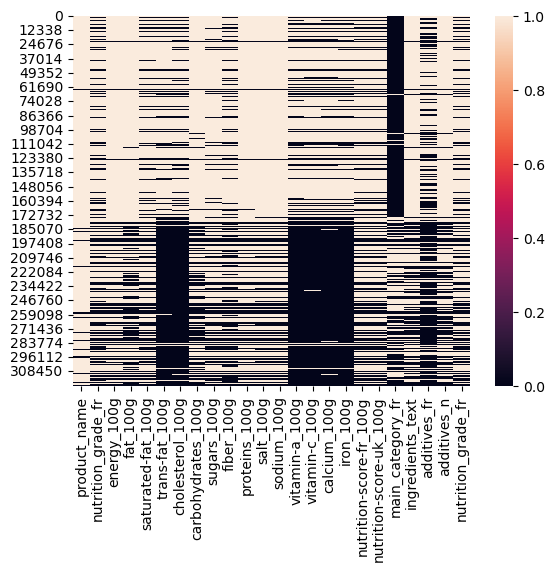

In [57]:
sns.heatmap(df_2.notna())

In [ ]:
print('Il reste ', df_2.shape[1], ' valeurs pertinentes.')

## Gestion des valeurs manquantes